# AI Coursework
I have decided to use a loan approval prediction dataset to solve the problem of predicting whether someone would get approved for a loan or not based on a variety of attributes associated with that individual. This will use classification to form the predictions and I will be using DecisionTreeClassifier and then the Keras Sequential Model as my neural network model. Both will be trained and tested on the same data.  

## Project Setup
The following imports the neccessary libraries and allows for file upload of the dataset in a google colab notebook.

In [21]:
import pandas as pd # for handling data in data frames
import numpy as np # for performing calculations and operations on data
import seaborn as sns # for visualising data
from sklearn.model_selection import train_test_split # for splitting data into train and test sets
import matplotlib.pyplot as plt # for plotting diagrams
import tensorflow as tf # for the keras sequential model
from sklearn.impute import SimpleImputer # for pre-procesing data by filling in missing values
from sklearn.tree import DecisionTreeClassifier # model for classifying the data
from sklearn.preprocessing import StandardScaler, LabelEncoder # for pre-processing the data
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # for calculating metrics on the data & models

In [2]:
from google.colab import files
uploaded = files.upload(); # upload train.csv dataset file in google colab

Saving train.csv to train.csv


# Data Pre-Processing and Visualisation
The following section explores the dataset, visualises the data and then pre-processes it ready for training.

### Visualise the data in form of table
View data in table form and view sum of missing values


In [3]:
# Load the CSV
trainDataset = pd.read_csv("train.csv") # read the csv file
trainDataset.head() # print first 5 rows

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df = trainDataset.drop(['Loan_ID'], axis=1) # Remove the Loan_ID column as it is unnecessary data
print(df.isna().sum()) # print the total number of null values in dataset

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [5]:
print(df.info()) # print info on the dataset and its dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB
None


In [6]:
# Using the simple imputer to fill in the missing values in the dataset using the mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialise label encoder for encoding string/object values to numeric form
le = LabelEncoder()

# Loop through each column in the data set and replace all object columns with the numeric encoded version of its value
for v in df:
  if df[v].dtype == 'object':
    df[v] = le.fit_transform(df[v])

# Loop through each column and fill in all missing values using the imputer then reshape the value array so it can replace the data in dataframe
for v in df.isna():
  df[v] = imputer.fit_transform(df[v].values.reshape(-1,1))

print(df.isna().sum())
print(df.dtypes)

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Gender               float64
Married              float64
Dependents           float64
Education            float64
Self_Employed        float64
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area        float64
Loan_Status          float64
dtype: object


## Pairplot showing categorical relationships
Below is a pairplot to analyse the relationships between the categorical features. It shows relationships like the higher the applicant income the higher their loan amount can be but it also shows that the applicants income doesn't really affect their loan term. Another relationship is that self employed people typically have less income and so that could affect their loan amount or chance of getting a loan. In general, the categorical features typically affect the loan amount more than they affect each other.

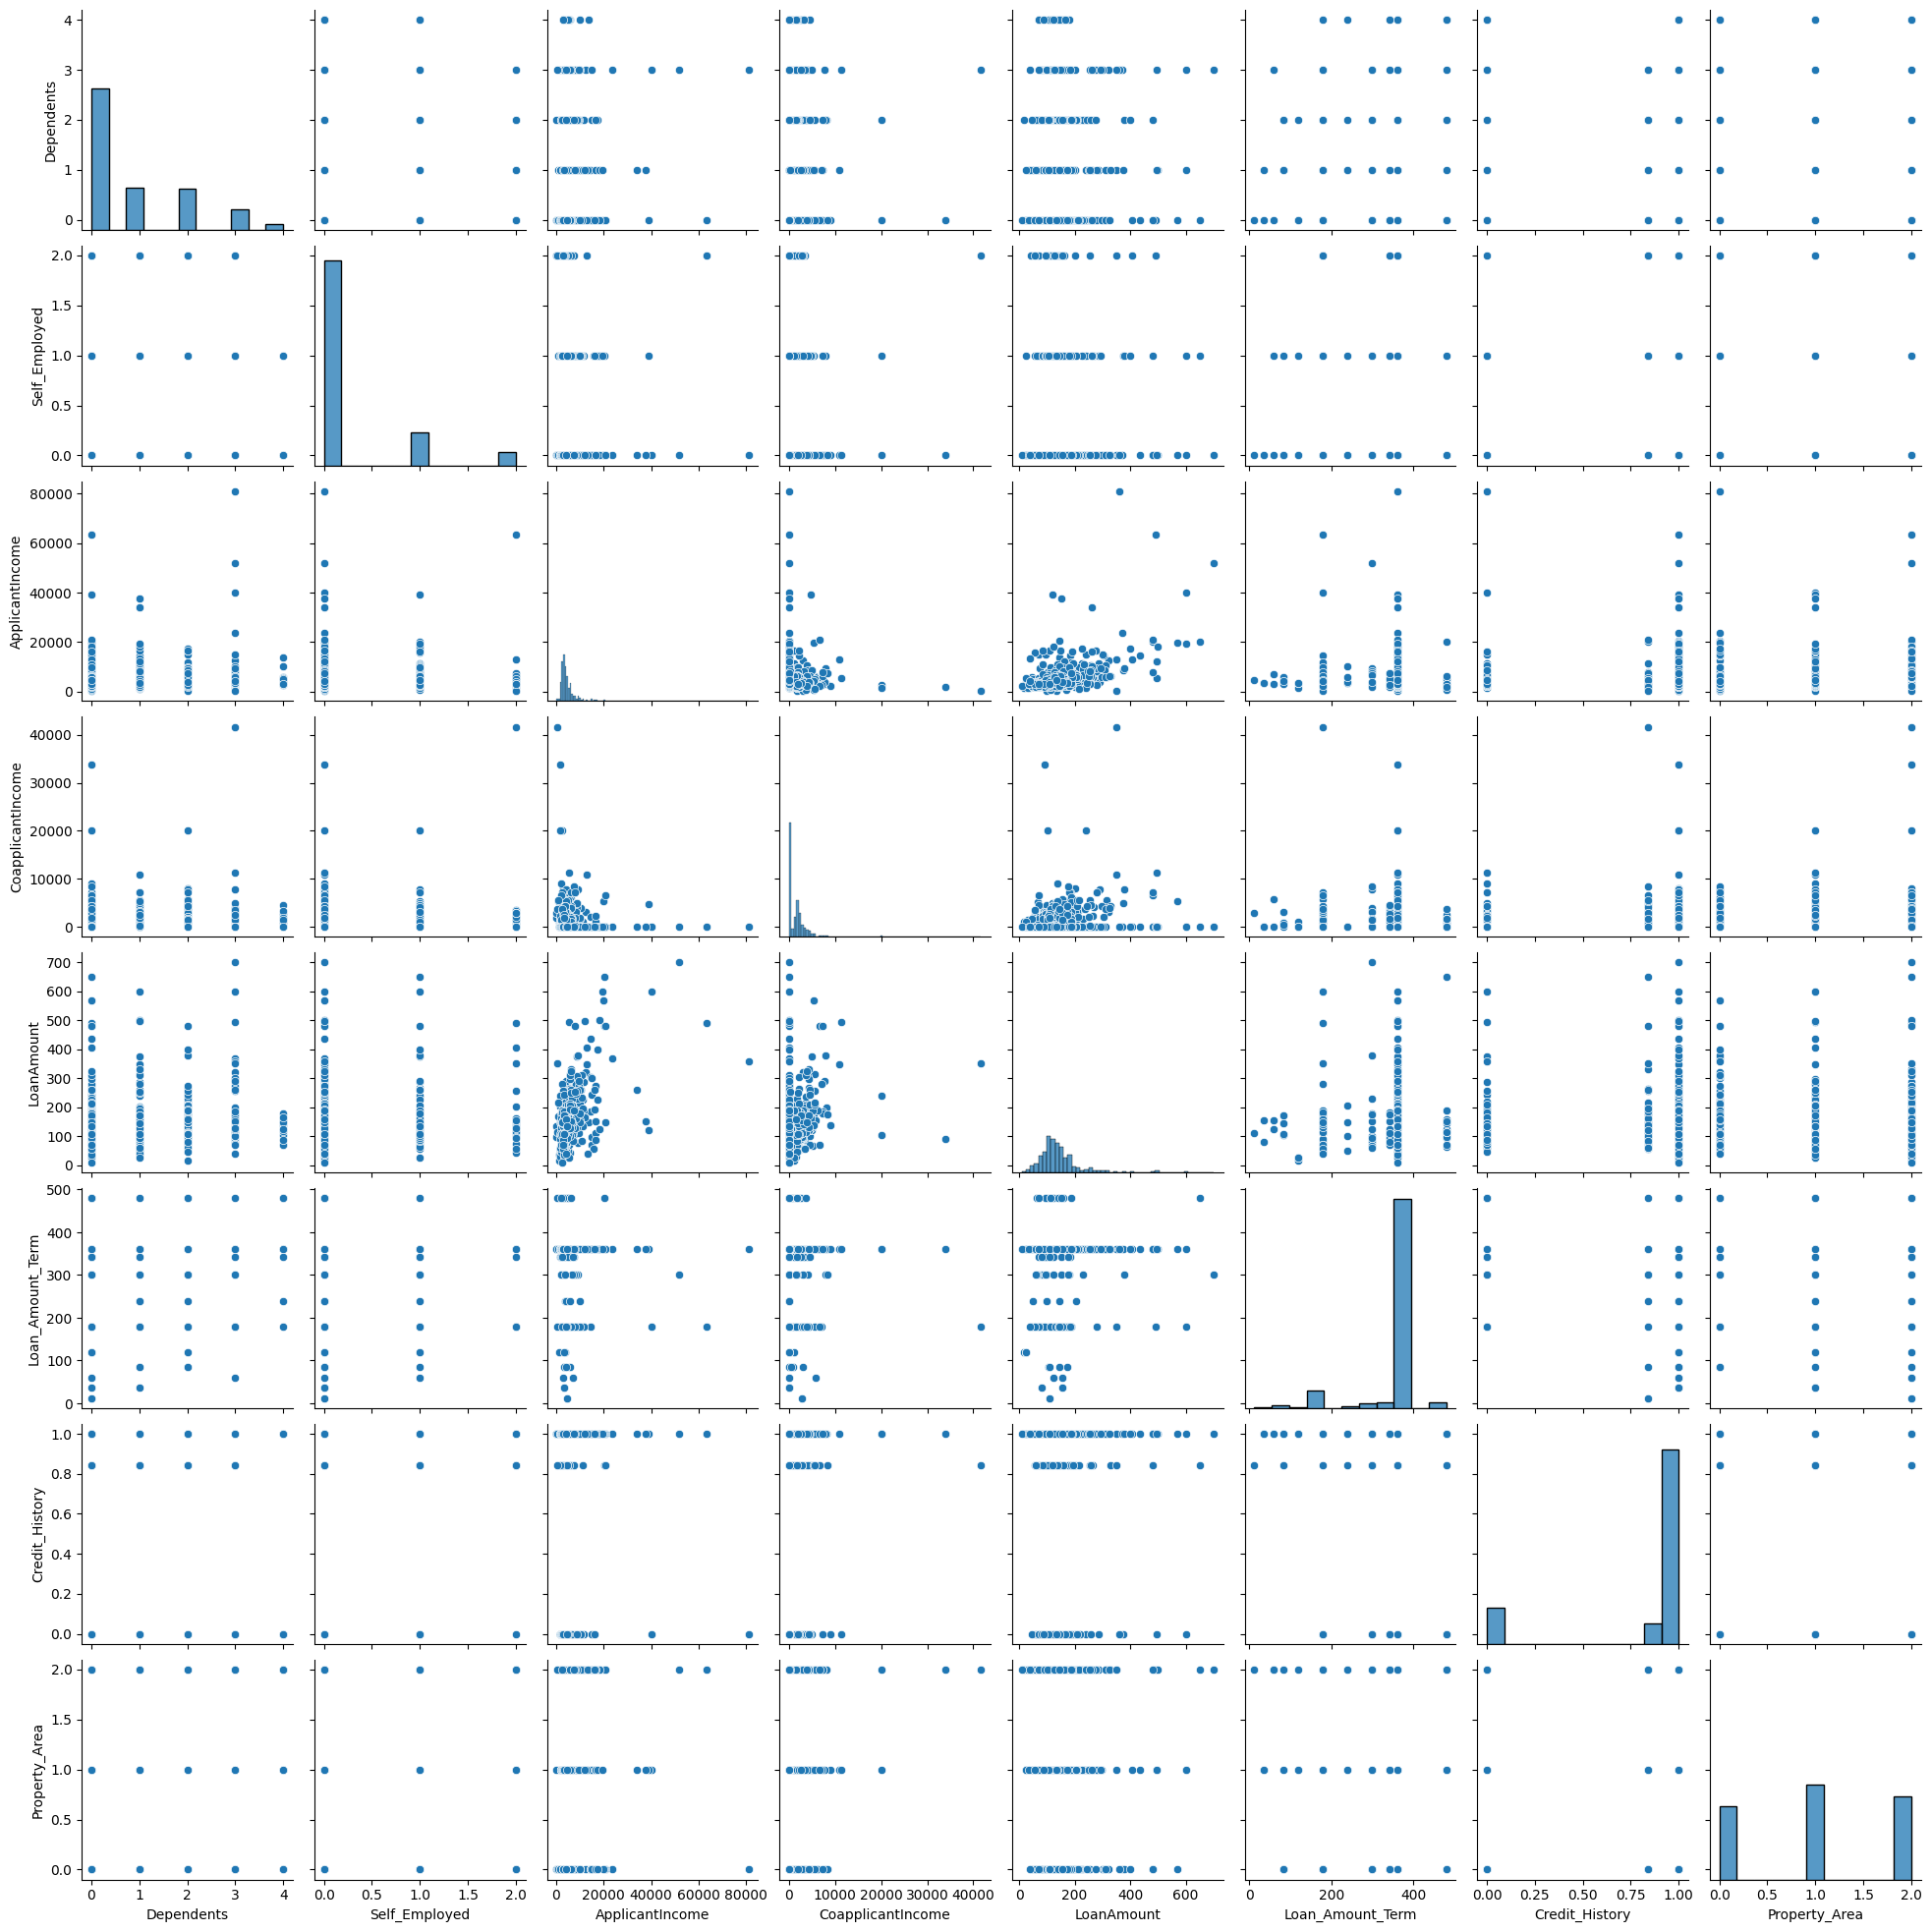

In [7]:
features = df.drop(['Gender', 'Married', 'Education', 'Loan_Status'], axis=1)
sns.pairplot(features)

In [8]:
np.set_printoptions(suppress=True) # prevent scientific notation from showing

x = np.array(features) # create array of the input features
y = np.array(df[['Loan_Status']]) # create array for the output feature

# Visualise the shapes of x and y
print(x.shape)
print(y.shape)

train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.15, random_state=10) # split the data where 15% data is for testing

# Pre-Process data by scaling the train_x and test_x sets using the StandardScaler so that the features are normalized which will help model accuracy & performance.
ss = StandardScaler()
train_x = ss.fit_transform(train_x)
test_x = ss.transform(test_x)

(614, 8)
(614, 1)


## Creating and Training models
I'm going to be using a DecisionTreeClassifier model and the Keras Sequential neural network model to predict solutions to the problem I've proposed.

In [9]:
loan_chances = ['No','Yes'] # 0 = No, 1 = Yes, used for output of the predicted values so that they are more readable
models = ['DecisionTreeClassifier', 'KerasSequential'] # Labels for the models used

# Iterate through each of the models
for m in models:
  print(f'Model: {m}') # print the model label
  if m == models[0]: # if the model is the decision tree classifier
    model = DecisionTreeClassifier() # initialize the DecisionTreeClassifier class
    model.fit(train_x, train_y) # fit the x and y train data to the model

    pred_y = model.predict(test_x) # predict the output using the x test data
    pred = pred_y
    print('Accuracy score:', accuracy_score(test_y, pred, normalize = True)*100) # use accuracy_score() to get the accuracy score and output it, multiply by 100 to make it a percentage.
    cm = confusion_matrix(test_y, pred) # create the confusion matrix for visualisation after training

  elif m == models[1]: # if the model is keras sequential
    model = tf.keras.Sequential() # intiialize keras sequential model
    model.add(tf.keras.layers.Input(shape=test_x.shape[1])) # create the input layer with the dimensions on the x shape
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu)) # create a dense layer
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu)) # create another hidden dense layer
    model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)) # output as a single value to determine whether they'd get approved or not in the prediction, sigmoid outputs as a probability between 0 and 1 so rounding it will determine Yes or No

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','binary_accuracy']) # compile the model using the adam optimizer and binary corssentropy as loss function because we're determining whether it is a 0 (no) or a 1 (yes)


    train = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=16, epochs=50, verbose=0) # train the model with the x and y train data with a batch size of 16 and 50 epochs
    pred = np.round(model.predict(test_x)) # predict with the x test data which determines whether individuals in applications would get approved or denied for the loan

    eval_test = model.evaluate(test_x, test_y);

    print(f'\nTest Loss: {eval_test[0]}, accuracy: {eval_test[1] * 100}, binary_accuracy: {eval_test[2] * 100}\n') # print accuracy score of test data as percentage
    print(f"\nTraining Accuracy score: {model.evaluate(train_x, train_y)[1] * 100}") # print accuracy score as percentage

  print(f'\nPredicted[0] | Approved for loan? : {loan_chances[int(pred[0].flatten()[0])]}\n') # to check it works this outputs the loan chance (Yes or No) for the first item in the x test data


Model: DecisionTreeClassifier
Accuracy score: 74.19354838709677

Predicted[0] | Approved for loan? : Yes

Model: KerasSequential
3/3 [==============================] - 0s 5ms/step - loss: 0.5832 - accuracy: 0.7957 - binary_accuracy: 0.7957

Test Loss: 0.5831724405288696, accuracy: 79.56989407539368, binary_accuracy: 79.56989407539368

17/17 [==============================] - 0s 2ms/step - loss: 0.3643 - accuracy: 0.8407 - binary_accuracy: 0.8407

Training Accuracy score: 84.06909704208374

Predicted[0] | Approved for loan? : Yes



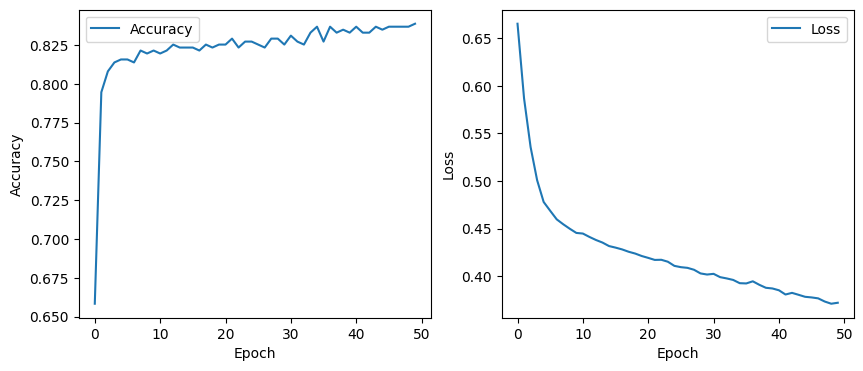

In [10]:
fig, (x1, x2) = plt.subplots(1,2, figsize=(10,4)) # create subplots for accuracy over time and loss over time

# plot the accuracy over time
x1.plot(train.history['accuracy'])
x1.set_xlabel('Epoch')
x1.set_ylabel('Accuracy')
x1.legend(['Accuracy'])

# plot the loss over time
x2.plot(train.history['loss'])
x2.set_xlabel('Epoch')
x2.set_ylabel('Loss')
x2.legend(['Loss'])
fig.show()

In [11]:
# Compare the predictions of the two models with the first item in the test set
result = []
testPrediction = ss.inverse_transform(test_x)[0]

for c in range(len(features.columns)):
  result.append(f'{features.columns[c]}: {testPrediction[c]}')

print(f'{result}\nKeras model prediction: {loan_chances[int(pred[0].flatten()[0])]}\nDecision tree prediction: {loan_chances[int(pred_y[0].flatten()[0])]}')

['Dependents: 0.0', 'Self_Employed: 0.0', 'ApplicantIncome: 3158.0', 'CoapplicantIncome: 3053.0', 'LoanAmount: 89.0', 'Loan_Amount_Term: 360.0', 'Credit_History: 1.0', 'Property_Area: 0.0']
Keras model prediction: Yes
Decision tree prediction: Yes


In [12]:
# Visualise the prediction results for each model for first 10 items
for i in range(0,10):
  print(f'(Item {i + 1}) Decision Tree Classifier Prediction: {loan_chances[int(pred_y[i].flatten()[0])]}')
  print(f'(Item {i + 1}) Keras Model Prediction: {loan_chances[int(pred[i].flatten()[0])]}\n')

(Item 1) Decision Tree Classifier Prediction: Yes
(Item 1) Keras Model Prediction: Yes

(Item 2) Decision Tree Classifier Prediction: No
(Item 2) Keras Model Prediction: Yes

(Item 3) Decision Tree Classifier Prediction: Yes
(Item 3) Keras Model Prediction: Yes

(Item 4) Decision Tree Classifier Prediction: Yes
(Item 4) Keras Model Prediction: Yes

(Item 5) Decision Tree Classifier Prediction: No
(Item 5) Keras Model Prediction: Yes

(Item 6) Decision Tree Classifier Prediction: Yes
(Item 6) Keras Model Prediction: Yes

(Item 7) Decision Tree Classifier Prediction: No
(Item 7) Keras Model Prediction: No

(Item 8) Decision Tree Classifier Prediction: Yes
(Item 8) Keras Model Prediction: Yes

(Item 9) Decision Tree Classifier Prediction: Yes
(Item 9) Keras Model Prediction: Yes

(Item 10) Decision Tree Classifier Prediction: Yes
(Item 10) Keras Model Prediction: Yes



Keras Model Confusion Matrix


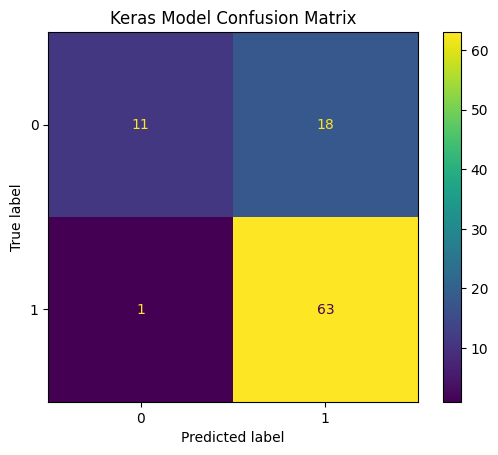

In [29]:
print("Keras Model Confusion Matrix")
conf = confusion_matrix(test_y, pred)
d = ConfusionMatrixDisplay(conf)
d.plot()
d.ax_.set_title("Keras Model Confusion Matrix")
plt.show()

Decision Tree Classifier Confusion Matrix


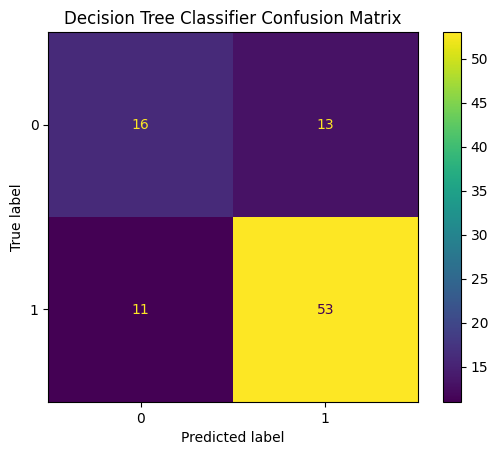

In [28]:
print("Decision Tree Classifier Confusion Matrix")
conf = confusion_matrix(test_y, pred_y)
d = ConfusionMatrixDisplay(conf)
d.plot()
d.ax_.set_title("Decision Tree Classifier Confusion Matrix")
plt.show()